### Attempt to replicate figure 1 from Kitanidis et al., 2019

In [1]:
import numpy as np
import pandas
from astropy.io import fits
from astropy.io import ascii
import random
import matplotlib.pyplot as plt
import wget
import seaborn as sns
import healpy as hp
from models.deep_set.set_dataloader import CCD
from desiutil.plots import plot_sky_binned



In [2]:
from platform import python_version
print(python_version())

3.8.8


In [3]:
#Open fits images // TODO --> Include North Bricks in Analysis
hdulistBricksSummary = fits.open('../../bricks_data/survey-bricks-dr9-south.fits')
dataSummary = hdulistBricksSummary[1].data
bricknameSummary = dataSummary.field('brickname')
raSummary = dataSummary.field('ra')
decSummary = dataSummary.field('dec')
brickIDSummary = dataSummary.field('brickid')
nobjsSummary = dataSummary.field('nobjs')
nexp_gSummary = dataSummary.field('nexp_g')
nexp_rSummary = dataSummary.field('nexp_r')
nexp_zSummary = dataSummary.field('nexp_z')

raDec = np.stack((raSummary, decSummary,nexp_gSummary,nexp_rSummary,nexp_zSummary), axis=-1)
print(raSummary)
print(decSummary)
print(raDec.shape)

print(nexp_gSummary)
print(raDec[:,2])


[1.25000000e-01 1.25000000e-01 1.25000000e-01 ... 3.59850000e+02
 3.59849498e+02 3.59849246e+02]
[-0.25 -0.5  -0.75 ... 33.75 34.   34.25]
(253658, 5)
[8 8 9 ... 2 1 0]
[8. 8. 9. ... 2. 1. 0.]


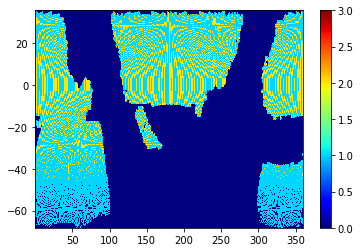

In [4]:
plt.hist2d(raSummary, decSummary, bins=(1000,416), cmap="jet")
plt.colorbar()
plt.show()

In [5]:
print(len(np.unique(raSummary)))
print(np.unique(raSummary))
print(len(np.unique(decSummary)))

binsRa = np.arange(-65, 285, 0.25)
binsDec = np.arange(-70, 40, 0.25)

149371
[1.25000000e-01 1.25173853e-01 1.25348189e-01 ... 3.59874652e+02
 3.59874826e+02 3.59875000e+02]
417


#### Exposure Density in G Band 

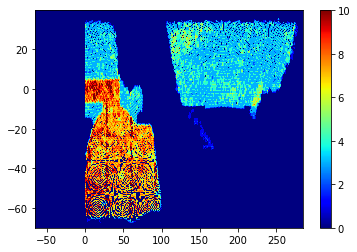

In [6]:
raExpG = np.zeros(nexp_gSummary.sum())
decExpG = np.zeros(nexp_gSummary.sum())

index = 0

for i in range(len(nexp_gSummary)):
    for j in range(nexp_gSummary[i]):
        raExpG[index] = raSummary[i]
        decExpG[index] = decSummary[i]
        index += 1

plt.hist2d(raExpG, decExpG, bins=[binsRa, binsDec], cmap="jet")
plt.clim(0,10)
plt.colorbar()
plt.show()

#### Exposure Density in R Band

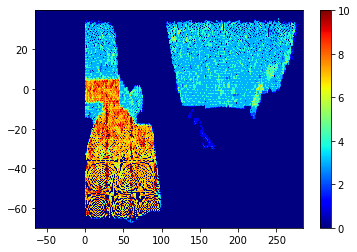

In [7]:
raExpR = np.zeros(nexp_rSummary.sum())
decExpR = np.zeros(nexp_rSummary.sum())

index = 0

for i in range(len(nexp_rSummary)):
    for j in range(nexp_rSummary[i]):
        raExpR[index] = raSummary[i]
        decExpR[index] = decSummary[i]
        index += 1

plt.hist2d(raExpR, decExpR, bins=[binsRa, binsDec],cmap="jet")
plt.clim(0,10)
plt.colorbar()
plt.show()

#### Exposure Density in Z Band

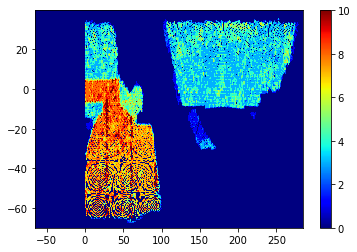

In [8]:
raExpZ = np.zeros(nexp_zSummary.sum())
decExpZ = np.zeros(nexp_zSummary.sum())

index = 0

for i in range(len(nexp_zSummary)):
    for j in range(nexp_zSummary[i]):
        raExpZ[index] = raSummary[i]
        decExpZ[index] = decSummary[i]
        index += 1

plt.hist2d(raExpZ, decExpZ, bins=[binsRa, binsDec], cmap="jet")
plt.clim(0,10)
plt.colorbar()
plt.show()


Calculate Exposure Densities using CCDs rather than Brick Information

In [3]:
# Setting NSIDE values
NSIDE = 256
NSIDE_SUB = 2048
NPIX = hp.nside2npix(NSIDE)
NPIX_SUB = hp.nside2npix(NSIDE_SUB)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))

Approximate resolution at NSIDE 256 is 0.23 deg


In [4]:
ccd = CCD()

### Exposures across all bands

Number of CCDs in Sample: 6776431
444259
Mean CCDs per Pixel: 15.253334203696493


0.0 180.0 -180.0 180.0


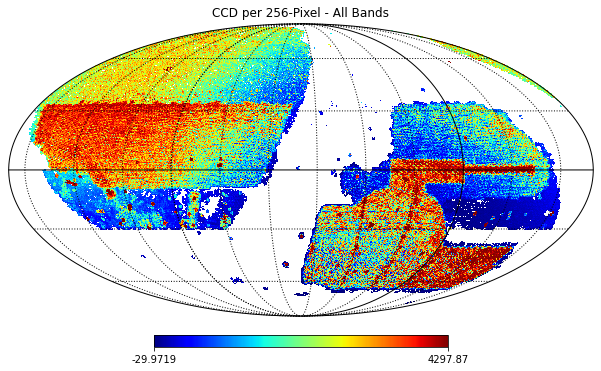

In [11]:
ra = ccd.ra
dec = ccd.dec
theta, phi = raDec2thetaPhi(ra, dec)

print("Number of CCDs in Sample:", len(ra))

m = np.zeros(NPIX)
pixel_indices = hp.ang2pix(NSIDE, theta,phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(pixel_indices, return_counts=True)

print(len(unique))
mean_CCDs = counts.mean()
print("Mean CCDs per Pixel:", mean_CCDs)
# Calculating Densities for every block

m[unique] = counts
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="CCD per 256-Pixel - All Bands", norm='hist',cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

2350130
Mean CCDs per Pixel: 2.883428150783148


0.0 180.0 -180.0 180.0


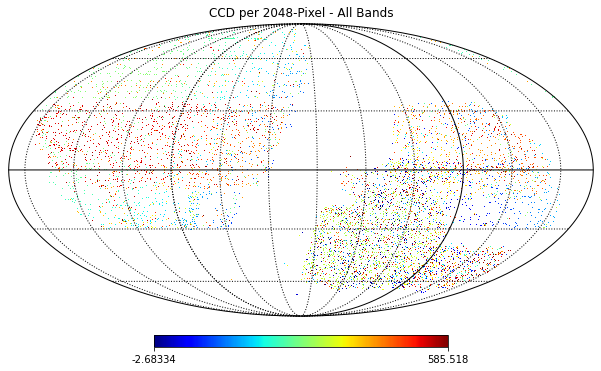

In [12]:
m = np.zeros(NPIX_SUB)
pixel_indices = hp.ang2pix(NSIDE_SUB, theta,phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(pixel_indices, return_counts=True)

print(len(unique))
mean_CCDs = counts.mean()
print("Mean CCDs per Pixel:", mean_CCDs)
# Calculating Densities for every block

m[unique] = counts
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="CCD per 2048-Pixel - All Bands", norm='hist',cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

Using 499 x 1563 grid in cos(DEC) x RA with pixel area 0.053 sq.deg.


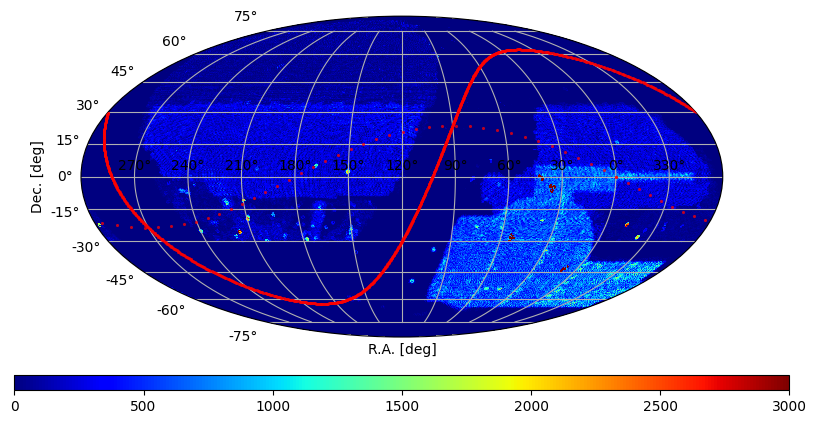

In [13]:
ax = plot_sky_binned(ra, dec, plot_type='grid', clip_hi=3000, max_bin_area=0.23**2, verbose=True, cmap='jet')

Using 67 x 206 grid in cos(DEC) x RA with pixel area 2.989 sq.deg.


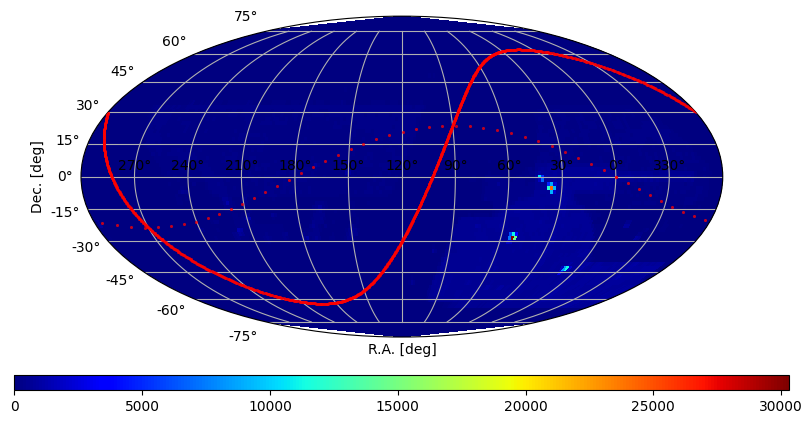

In [14]:
ax = plot_sky_binned(ra, dec, plot_type='grid', max_bin_area=3, verbose=True, cmap='jet')

### Exposures across g bands

Number of CCDs in Sample: 2236048
388593
Mean CCDs per Pixel: 5.754215850517122


0.0 180.0 -180.0 180.0


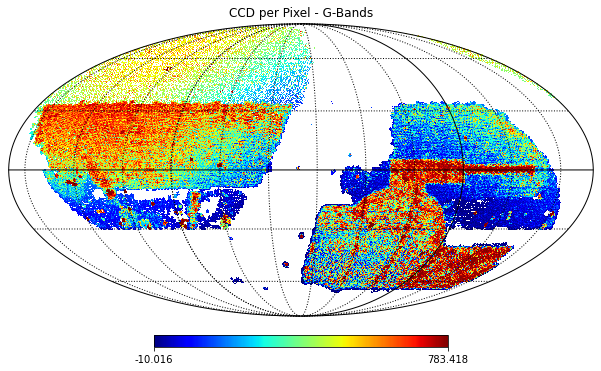

In [16]:
ra = ccd.ra
dec = ccd.dec

colour_mask = ccd.get_filter_mask('g')
ra = ra[colour_mask]
dec = dec[colour_mask]
theta, phi = raDec2thetaPhi(ra, dec)

print("Number of CCDs in Sample:", len(ra))

m = np.zeros(NPIX)
pixel_indices = hp.ang2pix(NSIDE, theta,phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(pixel_indices, return_counts=True)

print(len(unique))
mean_CCDs = counts.mean()
print("Mean CCDs per Pixel:", mean_CCDs)
# Calculating Densities for every block

m[unique] = counts
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="CCD per Pixel - G-Bands", norm='hist',cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

Using 499 x 1563 grid in cos(DEC) x RA with pixel area 0.053 sq.deg.


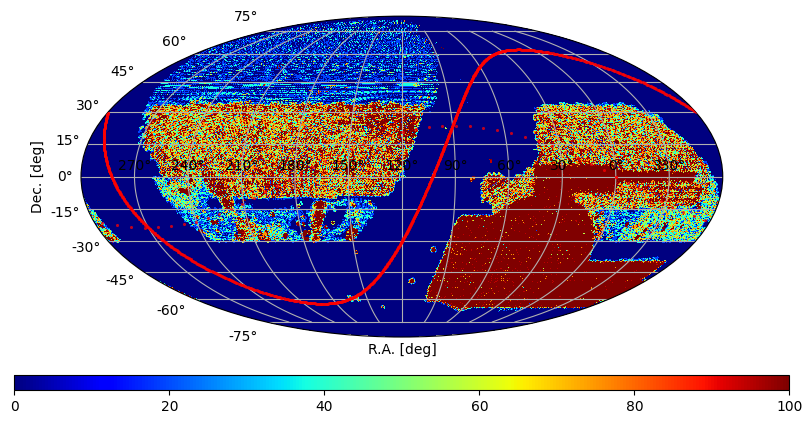

In [17]:
ax = plot_sky_binned(ra, dec, plot_type='grid', clip_hi=100, max_bin_area=0.23**2, verbose=True, cmap='jet')

Using 67 x 206 grid in cos(DEC) x RA with pixel area 2.989 sq.deg.


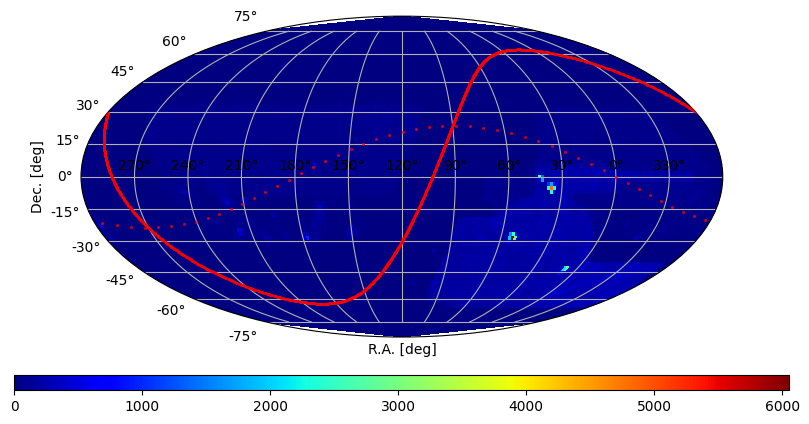

In [18]:
ax = plot_sky_binned(ra, dec, plot_type='grid', max_bin_area=3, verbose=True, cmap='jet')

### Exposures across r bands

Number of CCDs in Sample: 2074768
363306
Mean CCDs per Pixel: 5.710800262038061


0.0 180.0 -180.0 180.0


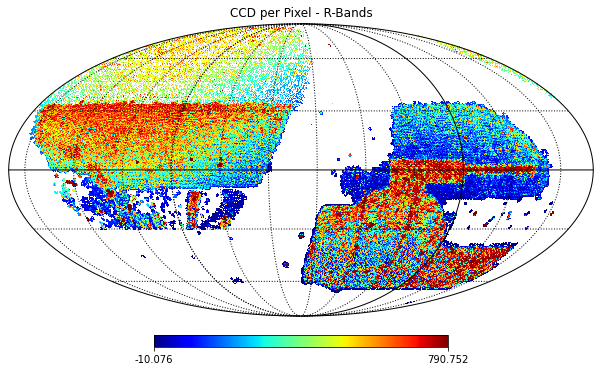

In [19]:
ra = ccd.ra
dec = ccd.dec

colour_mask = ccd.get_filter_mask('r')
ra = ra[colour_mask]
dec = dec[colour_mask]
theta, phi = raDec2thetaPhi(ra, dec)

print("Number of CCDs in Sample:", len(ra))

m = np.zeros(NPIX)
pixel_indices = hp.ang2pix(NSIDE, theta,phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(pixel_indices, return_counts=True)

print(len(unique))
mean_CCDs = counts.mean()
print("Mean CCDs per Pixel:", mean_CCDs)
# Calculating Densities for every block

m[unique] = counts
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="CCD per Pixel - R-Bands", norm='hist',cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

Using 499 x 1563 grid in cos(DEC) x RA with pixel area 0.053 sq.deg.


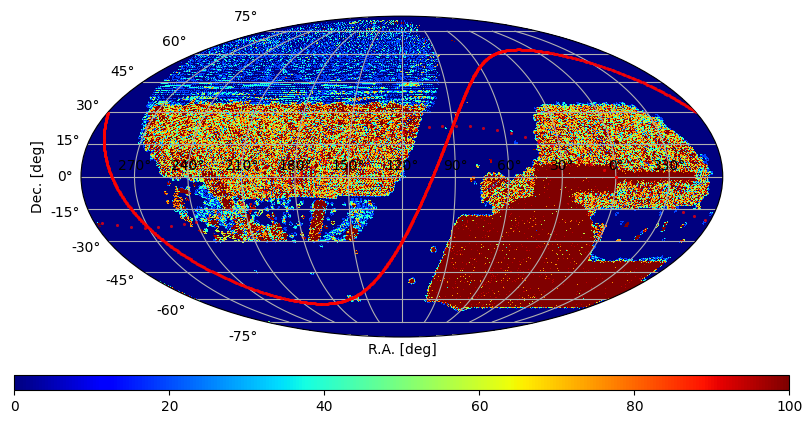

In [20]:
ax = plot_sky_binned(ra, dec, plot_type='grid', clip_hi=100, max_bin_area=0.23**2, verbose=True, cmap='jet')

Using 67 x 206 grid in cos(DEC) x RA with pixel area 2.989 sq.deg.


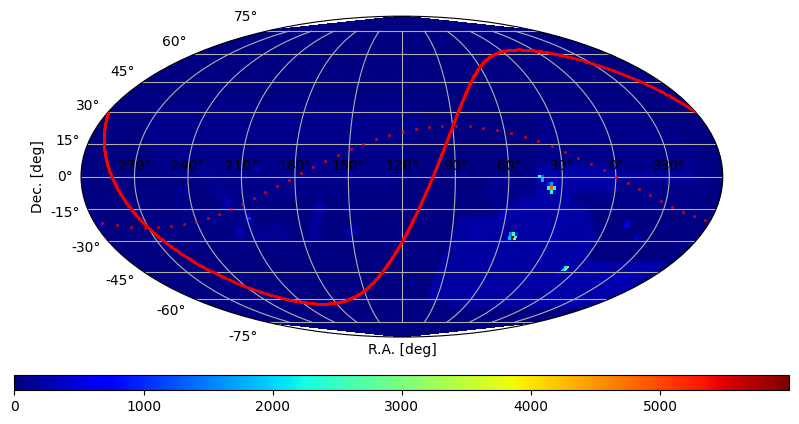

In [21]:
ax = plot_sky_binned(ra, dec, plot_type='grid', max_bin_area=3, verbose=True, cmap='jet')

### Exposures across z bands

Number of CCDs in Sample: 2465615
400169
Mean CCDs per Pixel: 6.16143429401078


0.0 180.0 -180.0 180.0


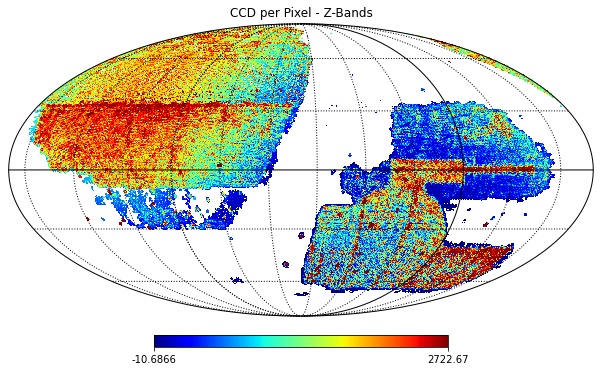

In [22]:
ra = ccd.ra
dec = ccd.dec

colour_mask = ccd.get_filter_mask('z')
ra = ra[colour_mask]
dec = dec[colour_mask]
theta, phi = raDec2thetaPhi(ra, dec)

print("Number of CCDs in Sample:", len(ra))

m = np.zeros(NPIX)
pixel_indices = hp.ang2pix(NSIDE, theta,phi)

# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(pixel_indices, return_counts=True)

print(len(unique))
mean_CCDs = counts.mean()
print("Mean CCDs per Pixel:", mean_CCDs)
# Calculating Densities for every block

m[unique] = counts
mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="CCD per Pixel - Z-Bands", norm='hist',cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

Using 499 x 1563 grid in cos(DEC) x RA with pixel area 0.053 sq.deg.


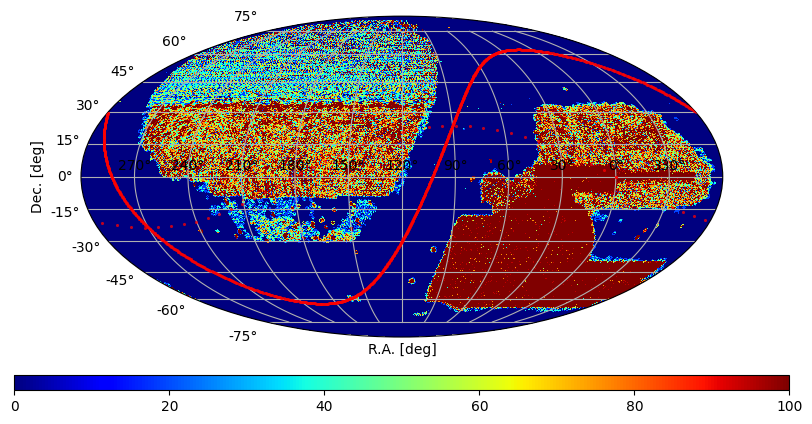

In [23]:
ax = plot_sky_binned(ra, dec, plot_type='grid', clip_hi=100, max_bin_area=0.23**2, verbose=True, cmap='jet')

Using 67 x 206 grid in cos(DEC) x RA with pixel area 2.989 sq.deg.


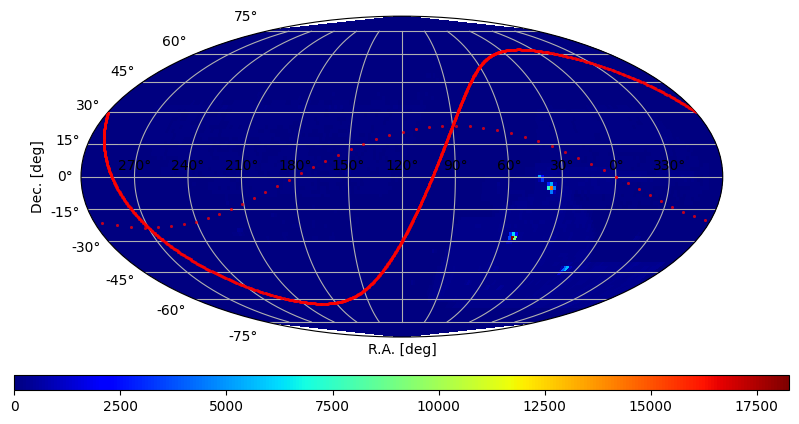

In [24]:
ax = plot_sky_binned(ra, dec, plot_type='grid', max_bin_area=3, verbose=True, cmap='jet')